# Trying out fitting a K2 transit of K2-9b (or EPIC 201465501) with Everest and MCMC

Packages used:
- BATMAN
- EVEREST
- exotk
- emcee
- astropy
- corner
- pyde

In [34]:
import everest
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
import sys
sys.path.append("../src/")
import everestmod
import astropy

# To make plots bigger
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] =200

In [16]:
#sys.path.remove('/Users/gks/Dropbox/mypylib')

In [17]:
star = everestmod.EverestMOD(201465501)

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201465501.


INFO  [everest.user.plot()]: Plotting the light curve...


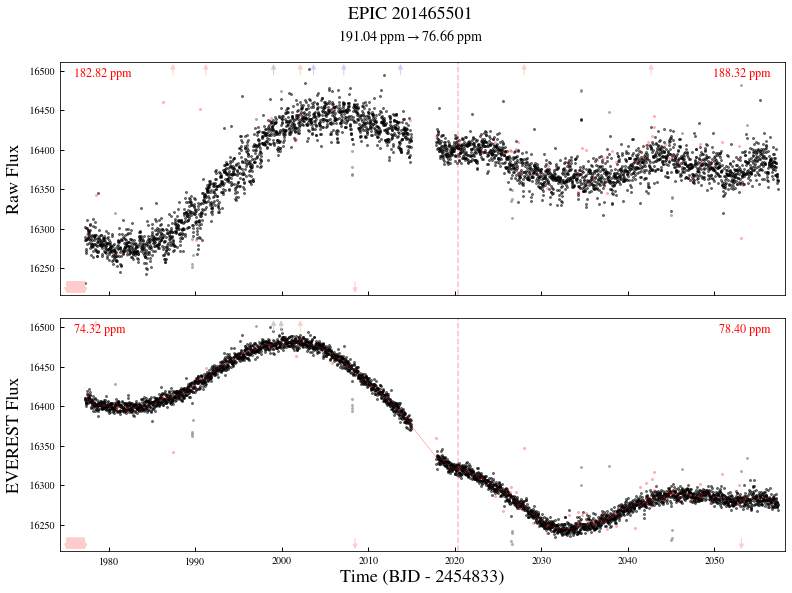

In [18]:
star.plot()

##### This epic target has known planet parameters from Crossfield et al. 2016

<img src="epic_table.png">

## Plot folded transit using Everest
This does not give us access to the flux arrays for some reason

In [19]:
t0      = 1989.6744
t0_err  = 0.028
per     = 18.4474
per_err = 0.0015
#star.mask_planet(t0,per)
#star.compute()
#star.plot_folded(t0,per)

#### Use everestmod to get access to the folded flux arrays

INFO  [everest.basecamp.compute()]: Computing the model...


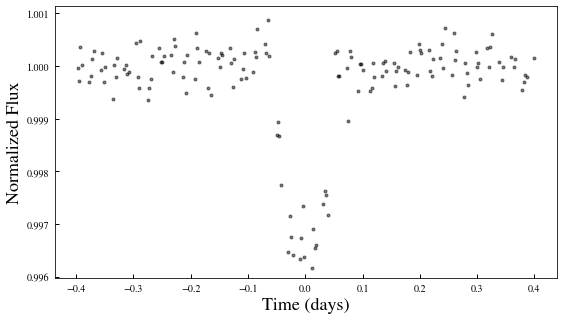

In [20]:
star.mask_planet(t0,per)
star.compute()
time, flux = star.get_folded_transit(t0,per,plot=True)

In [21]:
# Plot by hand
#pl.plot(time,flux,"k.")

# Fitting with MCMC

In [22]:
import tf
from priors import PriorSet, UP, NP, JP
import batman
import pyde
import math
from exotk.utils.likelihood import ll_normal_ev_py, ll_normal_es_py, ll_normal_es, ll_normal_ev
from scipy.optimize import minimize
import IPython
import ipywidgets
from IPython.display import display
from IPython.display import HTML
import corner
import emcee
import mcFunc

In [23]:


class LPFunction(object):
    """
    Log-Likelihood function class
    
    General philosophy:
    — Modify this for each fit
    — Outputs will be passed to emcee.sampler()
    — Outside of this are functions to plot the MCMC chains and corner plots
       
    NOTES:
    Based on hpprvi's awesome class, see: https://github.com/hpparvi/exo_tutorials
    
    I extended the Prior and Priorset classes in 
    /Users/gks/.local/lib/python2.7/site-packages/exotk
    """
    def __init__(self,number_pv_baseline=7,convergence_diagnostics=False):
        """
        Note: number_pv_baseline must be set to whatever the index of the 'fraw' parameter is
        """
        # This is only performed during initialization
        self.convergence_diagnostics = convergence_diagnostics
        self.number_pv_baseline = number_pv_baseline
                
        self.data= {"time"   : time, # phase folded time in days (centered on 0)
                    "flux"   : flux, # phase folded flux
                    "error"  : 1e-5, # asssumed fixed errorbar
                    }
        
        #####
        # Setting priors
        self.priors = [UP( -0.01               , 0.01                   , 'tc'       ,r'$T_C$'                 ,priortype="model"),  ##   0 - Transit centre, Tc
                       NP( 1.2659351647919772  , 0.001                  , 'logP'     ,r'$\log(P)$'             ,priortype="model"),  ##   1 - log(P)
                       UP( 0.                  , 0.034                  , 'cos(i)'   ,r'$\cos(i)$'             ,priortype="model"),  ##   2 - cos(i)
                       UP( 0.04                , 0.07                   , 'RpRs'     ,r'$R_p/R_s$'             ,priortype="model"),  ##   3 - rp/rstar
                       UP( 1.3                 , 1.7                    , 'log(a/Rs)',r'$\log(a/R_s)$'         ,priortype="model"),  ##   4 - log(a/rstar)     
                       UP( 0.                  , 1.                     , 'q1'       ,r'$q_1$'                 ,priortype="model"),  ##   5 - q1
                       UP( 0.                  , 1.                     , 'q2'       ,r'$q_2$'                 ,priortype="model"),  ##   6 - q2
                       UP( 0.9                 , 1.1                    , 'fraw'     ,r'fraw'                  ,priortype="model")]  ##   7 - Baseline constant
        
        # If we want to fix limb-dark parameters
        # self.limbdark = [ 0.16689202, 0.44493439] 
        self.ps     = PriorSet(self.priors)
        if self.convergence_diagnostics:
            self.maxiter     = 10000
            self.df_minimize = pd.DataFrame(index=range(self.maxiter),columns=self.ps.names+["log_ln"])
            self.index       = 0
        
    def compute_transit(self,pv,times=None):
        """
        Calls BATMAN and returns the transit model
        
        INPUT:
        pv    - parameters passed to the function 
        times - times, and array of timestamps 
        
        OUTPUT:
        lc - the lightcurve model at *times*
        """
        self.params = batman.TransitParams()
        self.params.t0 = pv[0]
        self.params.per = 10.**pv[1]
        self.params.inc = np.arccos(pv[2])*180./math.pi
        self.params.rp = pv[3]
        self.params.a = 10.**pv[4]
        
        self.params.ecc = 0.
        self.params.w = 0.
        q1, q2 = pv[5], pv[6]
        self.params.u = mcFunc.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        #self.params.u = self.limbdark
        self.params.limb_dark = "quadratic"
        self.params.fp = 0.001
        if times==None:
            times = self.data["time"]        
        transitmodel = batman.TransitModel(self.params, times, transittype='primary')
        self.lc = transitmodel.light_curve(self.params)
        return self.lc        
    
    def detrend(self,pv):
        """
        A function to detrend.
        
        INPUT:
        pv    - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
        detrend/pv[self.number_pv_baseline] - the additional trend in the data (no including transit)
        """
        detrend = np.zeros(len(self.data["flux"]))
        
        # loop over detrend parameters
        for i in self.ps.get_param_type_indices(paramtype="detrend"):
            #print(i)
            detrend += pv[i]*(self.data[self.ps.labels[i]]-1.)
        return detrend/pv[self.number_pv_baseline]
        
    def compute_lc_model(self,pv):
        """
        Compute the light curve model with detrend
        
        INPUT:
        pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
        The full light curve model with a trend
        
        TODO:
        - Choose to use GPs ?
        """
        return self.compute_transit(pv) + self.detrend(pv)
    
                    
    def __call__(self,pv):
        """
        Return the log likelihood
        
        NOTES:
        This is done each time an instance is called
        """
        # If priors are outside of bounds, return -inf
        #if all(pv > self.ps.pmins) and all(pv<self.ps.pmaxs):
            #print("within bounds")
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            #print("out of bounds")
            #print("Too low:",np.array(self.ps.names)[pv<self.ps.pmins])
            #print("Too high:",np.array(self.ps.names)[pv>self.ps.pmaxs],np.array(pv)[pv>self.ps.pmaxs])
            return -np.inf
        # make sure that sqrtecosw is well behaved
        flux_m = self.compute_lc_model(pv)
        
        # Return the log-likelihood
        log_of_priors = self.ps.c_log_prior(pv)
        scaled_flux   = self.data["flux"]/pv[self.number_pv_baseline]
        log_of_model  = ll_normal_es_py(scaled_flux, flux_m, self.data["error"])
        
        log_ln = log_of_priors + log_of_model
        
        if self.convergence_diagnostics==True:
            self.df_minimize.loc[self.index] = np.hstack([pv,log_ln])
            self.index += 1
        return log_ln

In [24]:
# Initialize an instance of the Transit Fitter Class, using the LPFunction as defined above
TF = tf.TransitFit(LPFunction,convergence_diagnostics=False)

Running PyDE Optimizer
Optimized using PyDE
('Final parameters:', array([-0.00160376,  1.2686633 ,  0.01992185,  0.0590326 ,  1.59106547,
        0.62905541,  0.20660973,  1.00001596]))
('LogLn value:', 75212.441857947371)
('Log priors', 15.593155155775332)
Running MCMC
Finished MCMC
Plotting MCMC optimized transit


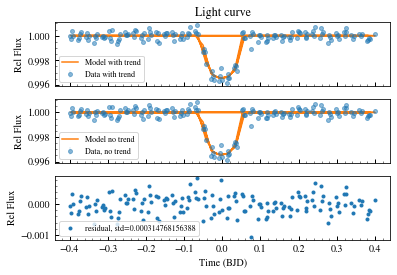

In [25]:
# Call the transit fitter.
# It does two main things:
# 1. Do an initial global optimization using PyDE
# 2. Do an MCMC run around the global minimum
TF()

Plotting chains


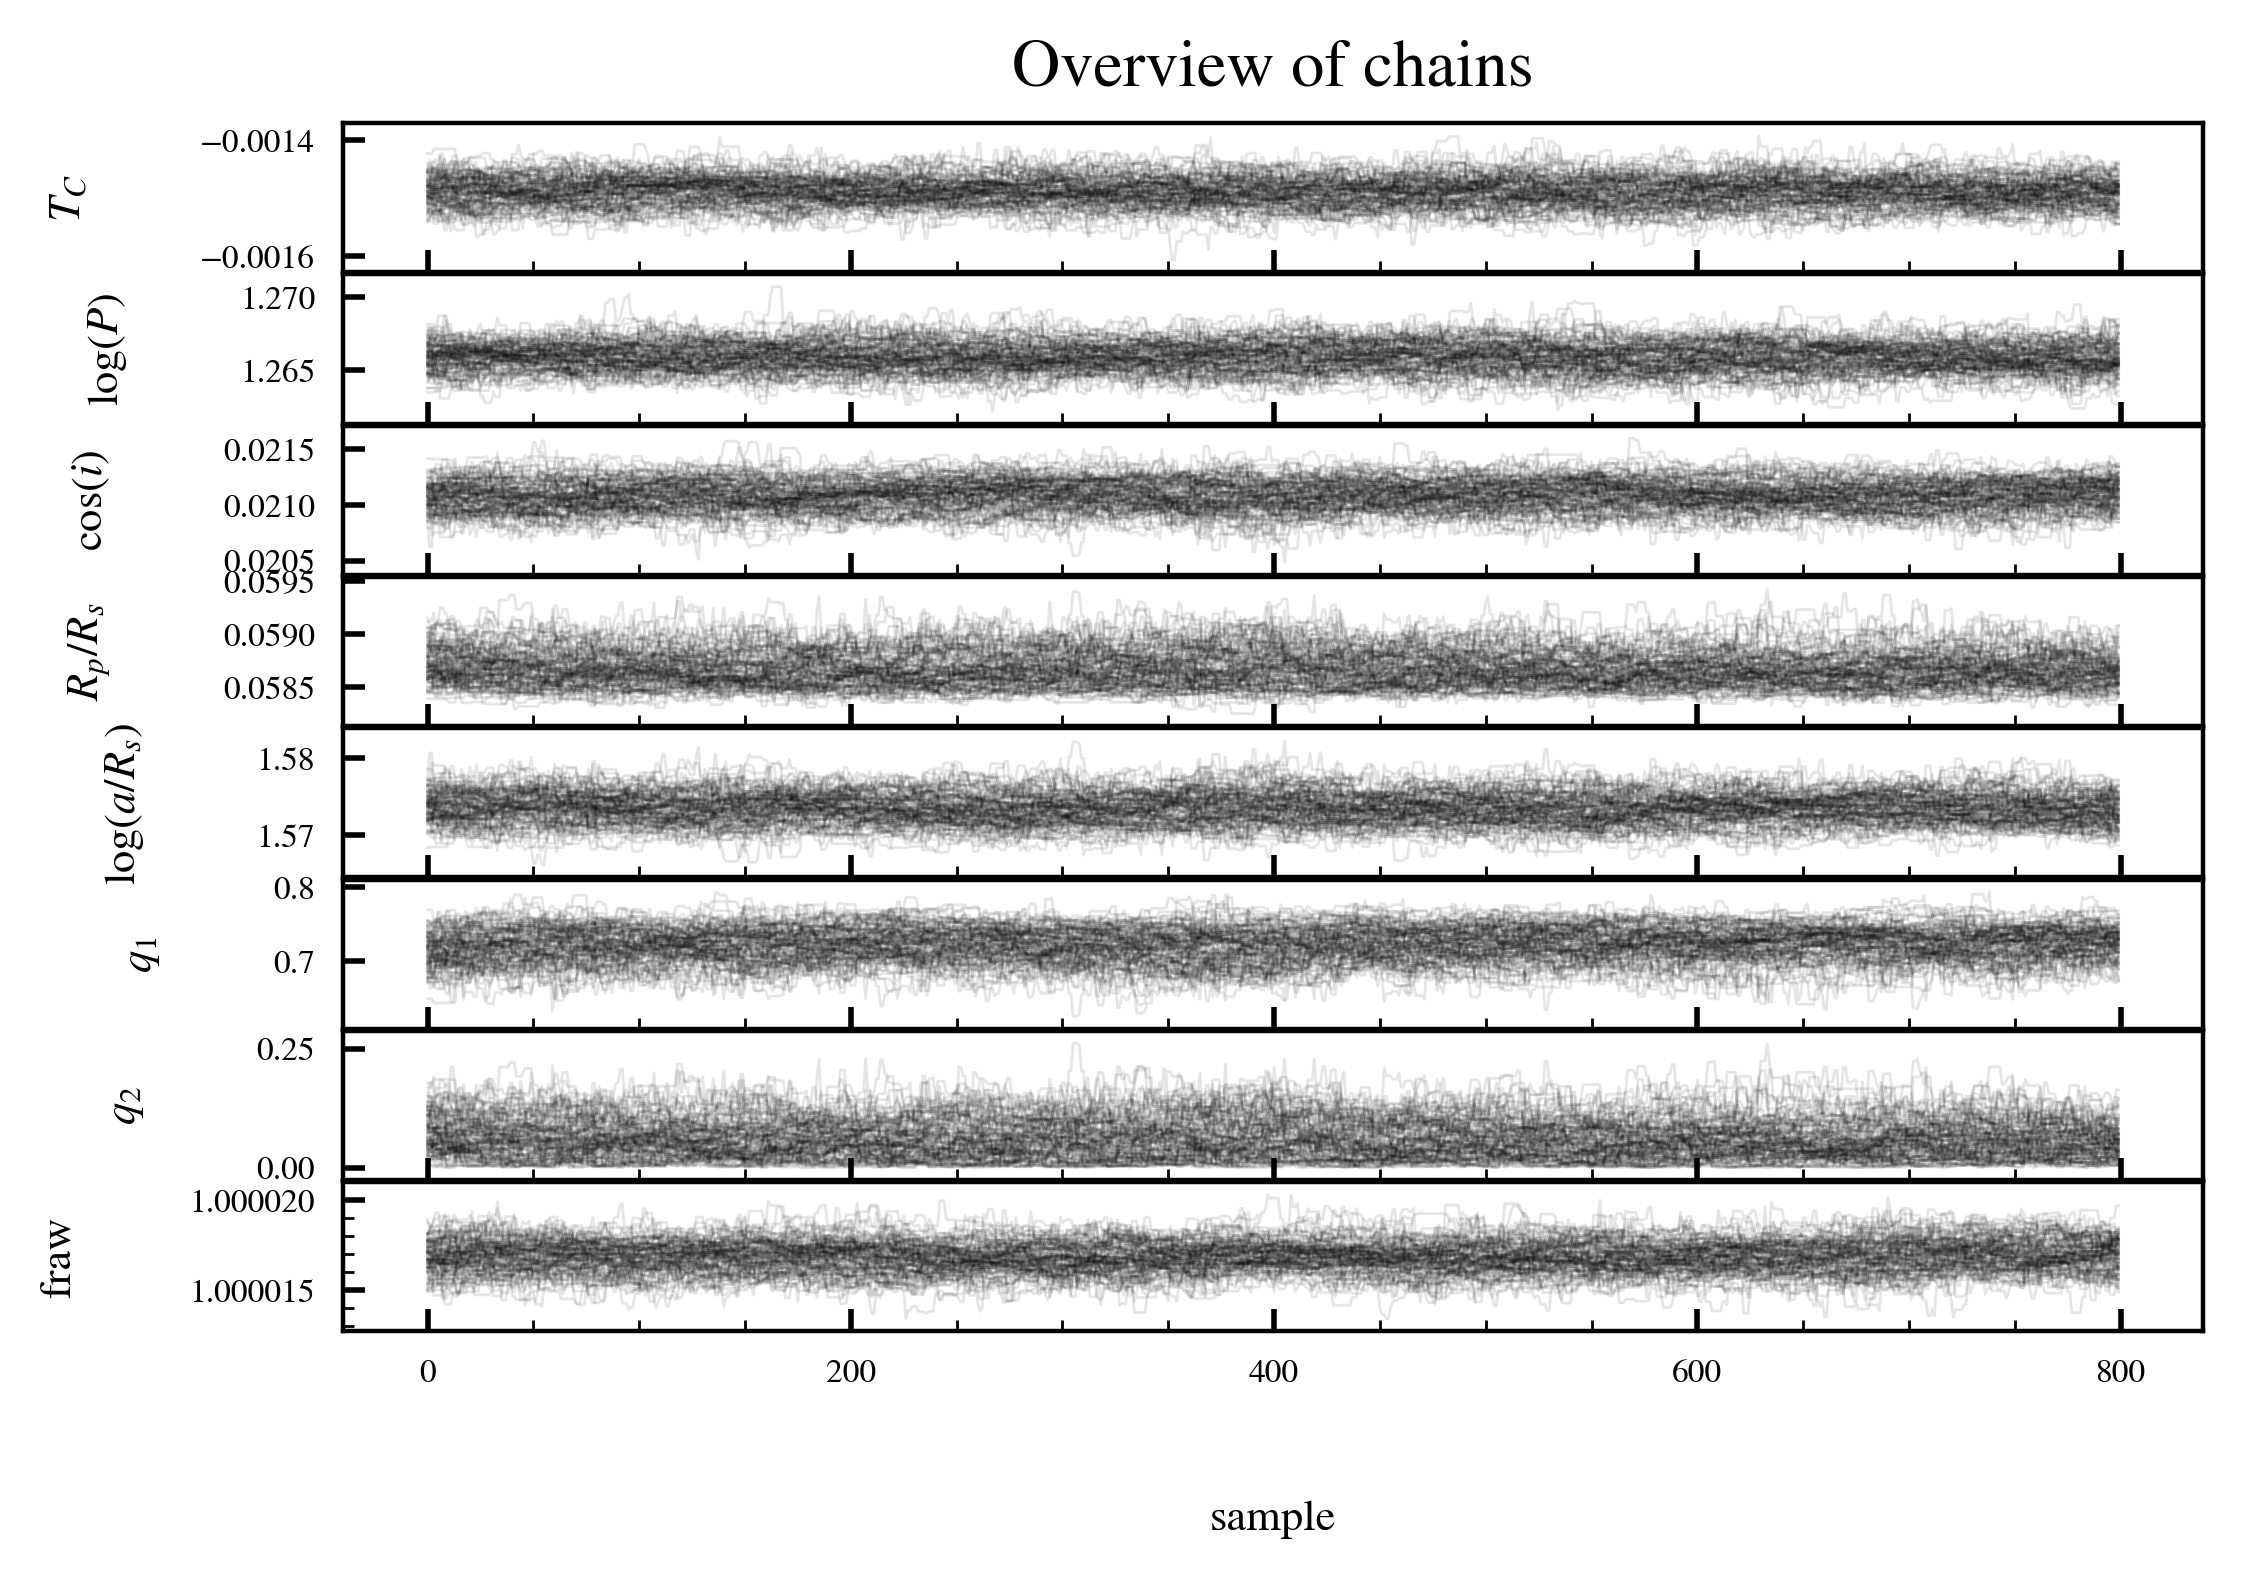

In [33]:
# Plot the chains, very useful for diagnostics. Check first with burn=0, to see if there are burn-in effects
TF.plot_chains(burn=200)

Plotting cornerplot


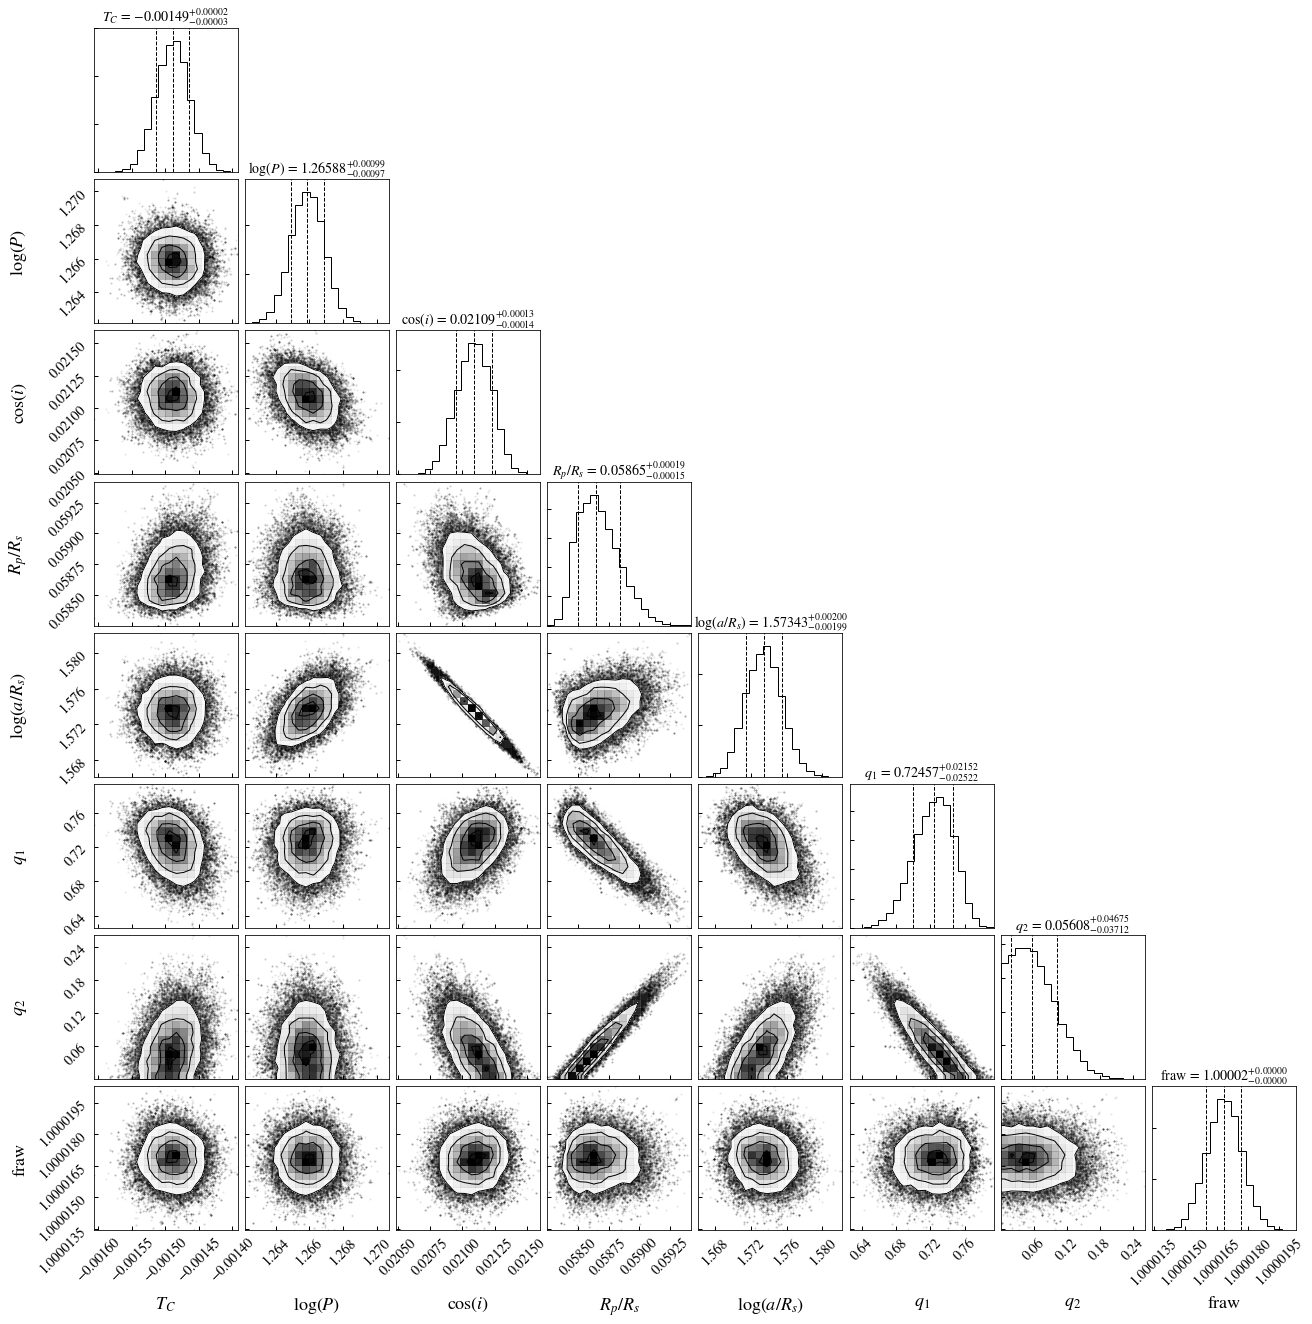

In [27]:
# Plot a corner plot
# 
TF.plot_corner(burn=200,show_titles=True)

In [28]:
# Get the planet parameters
TF.get_transit_parameters(burn=0,thin=1,st_rad=0.9,st_raderr1=0.01,st_teff=4000.,st_teff_err1=50.)

Assuming
('R_s:', 0.9, '+-', 0.01)
('Teff:', 4000.0, '+-', 50.0)
16


,medvals,minus,plus,values,Labels,Description
0,-0.001487,0.000026,0.000026,$-0.001487_{-0.00003}^{+0.00003}$,$T_{0}$ $(\mathrm{BJD_{TDB}})$,Transit Midpoint
1,18.448205,0.042914,0.041518,$18.448_{-0.043}^{+0.042}$,$P$ (days),Orbital period
2,0.058688,0.000172,0.000268,$0.05869_{-0.00017}^{+0.00027}$,$R_p/R_*$,Radius ratio
3,5.764550,0.067105,0.069909,$5.765_{-0.067}^{+0.070}$,$R_p (R_\oplus)$,Planet radius
4,0.514283,0.005987,0.006237,$0.5143_{-0.0060}^{+0.0062}$,$R_p (R_J)$,Planet radius
5,0.003444,0.000020,0.000032,$0.003444_{-0.00002}^{+0.00003}$,$\delta$,Transit depth
6,37.478151,0.185637,0.218918,$37.48_{-0.19}^{+0.22}$,$a/R_*$,Normalized orbital radius
7,0.156893,0.001921,0.002031,$0.1569_{-0.0019}^{+0.0020}$,$a$ (AU),Semi-major axis
8,88.792822,0.008389,0.009681,$88.7928_{-0.0084}^{+0.0097}$,$i$ $(^{\circ})$,Transit inclination
9,0.789544,0.001927,0.001679,$0.7895_{-0.0019}^{+0.0017}$,$b$,Impact parameter


In [29]:
# Get the posteriors
TF.df_post

,t0,per,RpRs,R_e,R_j,depth,aRs,aAU,inc,b,e,w,Teq,t14,tau,tS
0,-0.001564,18.482425,0.059552,5.922690,0.528391,0.003546,37.459353,0.158838,88.777324,0.799312,0.0,0.0,465.380457,0.109266,0.015711,9.239648
1,-0.001564,18.482425,0.059552,5.854190,0.522280,0.003546,37.459353,0.157001,88.777324,0.799312,0.0,0.0,475.016721,0.109266,0.015711,9.239648
2,-0.001564,18.482425,0.059552,5.772381,0.514981,0.003546,37.459353,0.154807,88.777324,0.799312,0.0,0.0,459.089883,0.109266,0.015711,9.239648
3,-0.001429,18.474543,0.059471,5.951909,0.530998,0.003537,37.973090,0.162031,88.805835,0.791382,0.0,0.0,452.415025,0.109117,0.015195,9.235842
4,-0.001405,18.469508,0.059500,5.947796,0.530631,0.003540,37.880966,0.161447,88.802304,0.791796,0.0,0.0,455.066991,0.109287,0.015249,9.233348
5,-0.001434,18.521480,0.059669,5.869117,0.523611,0.003560,38.511427,0.161502,88.830982,0.785702,0.0,0.0,451.248107,0.108879,0.014886,9.259306
6,-0.001434,18.521480,0.059669,5.872661,0.523928,0.003560,38.511427,0.161600,88.830982,0.785702,0.0,0.0,465.304900,0.108879,0.014886,9.259306
7,-0.001426,18.482644,0.059596,5.887023,0.525209,0.003552,38.395066,0.161704,88.827516,0.785650,0.0,0.0,462.723746,0.108972,0.014880,9.239896
8,-0.001426,18.482644,0.059596,5.811205,0.518445,0.003552,38.395066,0.159622,88.827516,0.785650,0.0,0.0,447.309497,0.108972,0.014880,9.239896
9,-0.001426,18.482644,0.059596,5.874225,0.524067,0.003552,38.395066,0.161353,88.827516,0.785650,0.0,0.0,455.928892,0.108972,0.014880,9.239896


In [30]:
# Example parameters
TF.lpf.ps.centers

[0.0, 1.2659351647919772, 0.017, 0.05500000000000001, 1.5, 0.5, 0.5, 1.0]

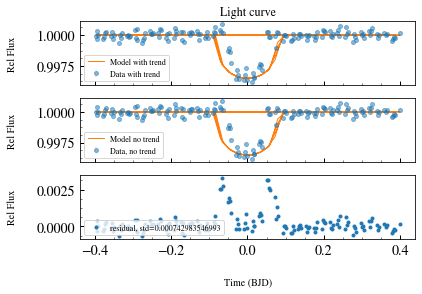

In [31]:
# Plot example parameters
# Code in an test example planet parameters
# This should not be a perfect fit, as we are just using some parameters by hand
pv = [0.0, 1.2659351647919772, 0.017, 0.055, 1.5, 0.5, 0.5, 1.0]
TF.plot_lc(pv)